### Titanic predictions Kaggle project
This notebook is a solution to the Titanic survivors ML kaggle competition here: https://www.kaggle.com/competitions/titanic/overview
There is plenty of code in here borrowed and tweaked from a few different sources:
1. The notbooks in the Udemy class
2. this titanic solution: https://www.kaggle.com/code/kabure/titanic-eda-model-pipeline-keras-nn#notebook-container
3. this titanic solution: https://www.kaggle.com/code/zaidali11/eda-feature-engineering-xgb-lgbm

Prediction score of this model is relatively low - around 79%, though it is slightly better than the control prediction: assuming all women survive and all men don't.

All in all, it seems a DNN is not the best solution for this problem, but I wanted to use it for a couple reasons: first becuase that is what we learned in the Udemy class, and second becuase I do think it is applicable for more work-related projects.

For questions, send me a ping or an email
Ian Rosado
ian.rosado@intel.com

### Import libs


In [34]:

import pandas as pd 
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
# Library to work with Regular Expressions
import re

# This function makes the plot directly on browser
%matplotlib inline

# Seting a universal figure size 
rcParams['figure.figsize'] = 10,8

### Import Data

In [35]:
# Importing train dataset
df_train = pd.read_csv("train.csv")

# Importing test dataset
df_test = pd.read_csv("test.csv")

### Look at data shape

In [36]:
#Looking data format and types
print(df_train.info())

# printing test info()
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

We can see several of the columns have Null values, so we will have to deal with that.

In [37]:
#Some Statistics
df_train.describe()



,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [38]:
#Take a look at the data
print(df_train.head())
#print(df_test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


### Some feature engineering

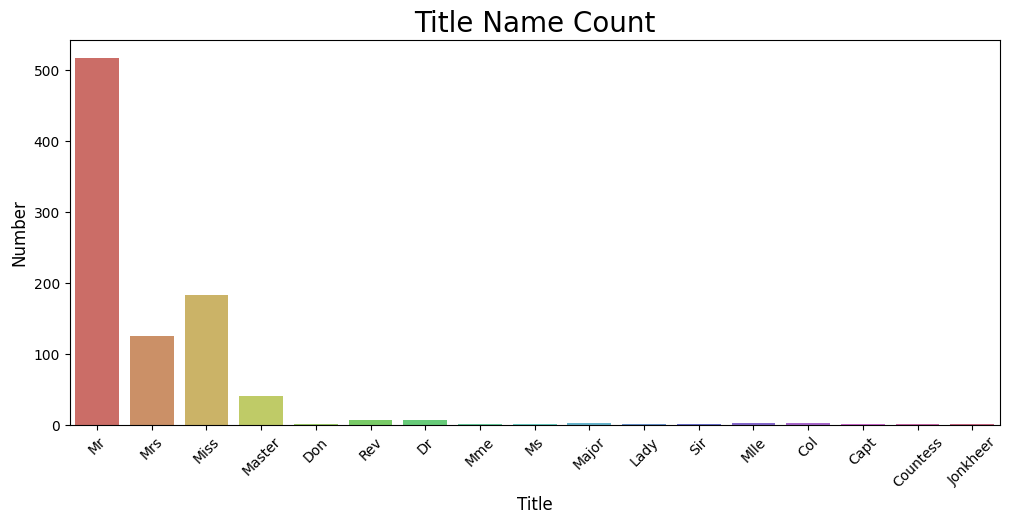

In [39]:
#The passenger names have titles that end in a period.  we can search for the word before the period to split them out
df_train['Title'] = df_train.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

#Doing the same on df_test
df_test['Title'] = df_test.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

#defining the figure size of our graphic
plt.figure(figsize=(12,5))

#Plotting the result
sns.countplot(x='Title', data=df_train, palette="hls")
plt.xlabel("Title", fontsize=12) #seting the xtitle and size
plt.ylabel("Number", fontsize=12) # Seting the ytitle and size
plt.title("Title Name Count", fontsize=20) 
plt.xticks(rotation=45)
plt.show()



That worked pretty well!  we can throw that in the model, or maybe group these together further to make it simpler

In [40]:
#group together different titles (because 17 is a lot and most don't have many people)
Title_Dictionary = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Lady" :      "Royalty",
        "Mme":        "Mrs",
        "Ms":         "Mrs",
        "Mrs" :       "Mrs",
        "Mlle":       "Miss",
        "Miss" :      "Miss",
        "Mr" :        "Mr",
        "Master" :    "Master"
                   }
    
# we map each title to correct category
df_train['Title'] = df_train.Title.map(Title_Dictionary)
df_test['Title'] = df_test.Title.map(Title_Dictionary)

Chances to survive based on titles: 
Title
Master     0.575000
Miss       0.701087
Mr         0.156673
Mrs        0.795276
Officer    0.277778
Royalty    0.500000
Name: Survived, dtype: float64


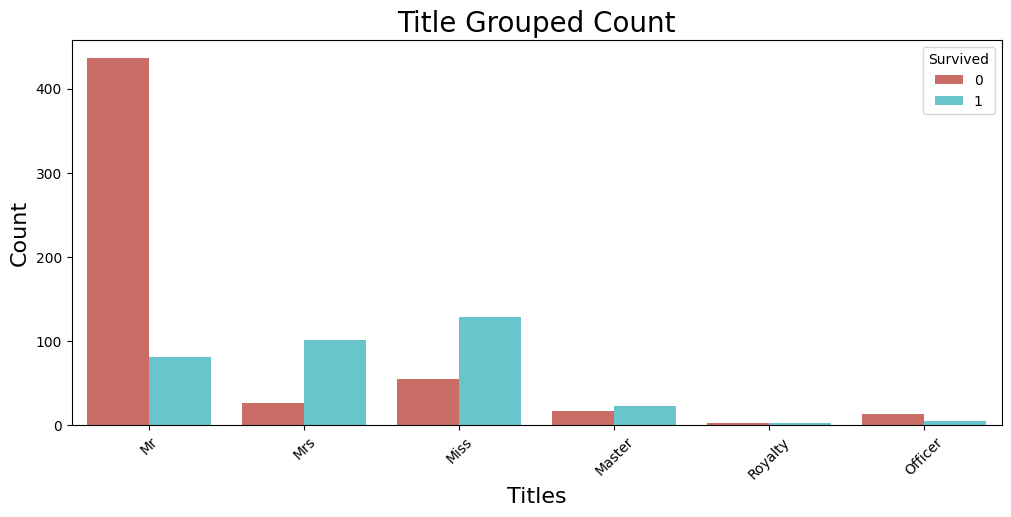

In [41]:
#printing the chance to survive by each title
print("Chances to survive based on titles: ") 
print(df_train.groupby("Title")["Survived"].mean())

# figure size
plt.figure(figsize=(12,5))

#Plotting the count of title by Survived or not category
sns.countplot(x='Title', data=df_train, palette="hls",
              hue="Survived")
plt.xlabel("Titles", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Title Grouped Count", fontsize=20)
plt.xticks(rotation=45)
plt.show()

### Adding a column for cabin
categorical - those without a cabin will get cabin 'n'

Chances to survive based on having a cabin: 
Cabin_letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64


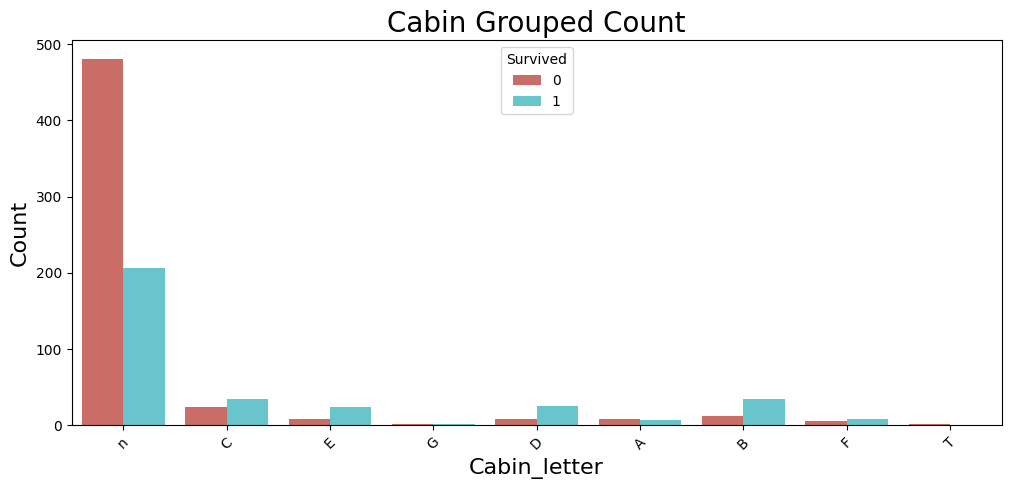

In [42]:
# add a new column that just takes the letter of the cabin
df_train['Cabin_letter'] = df_train['Cabin'].astype(str).str[0]
df_test['Cabin_letter'] = df_test['Cabin'].astype(str).str[0]

#printing the chance to survive by each title
print("Chances to survive based on having a cabin: ") 
print(df_train.groupby("Cabin_letter")["Survived"].mean())

# figure size
plt.figure(figsize=(12,5))

#Plotting the count of title by Survived or not category
sns.countplot(x='Cabin_letter', data=df_train, palette="hls",
              hue="Survived")
plt.xlabel("Cabin_letter", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Cabin Grouped Count", fontsize=20)
plt.xticks(rotation=45)
plt.show()

### Adding a column for ticket type
we'll have to do some real work t make this useable

Chances to survive based on ticket type: 
Ticket_item
A    0.068966
C    0.340426
F    0.571429
N    0.383459
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64


C:\Users\iprosado\AppData\Local\Temp\ipykernel_35020\4000255377.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Ticket_item"] = df["Ticket_item"].str.replace(char,'')
C:\Users\iprosado\AppData\Local\Temp\ipykernel_35020\4000255377.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Ticket_item"] = df["Ticket_item"].str.replace(char,'')


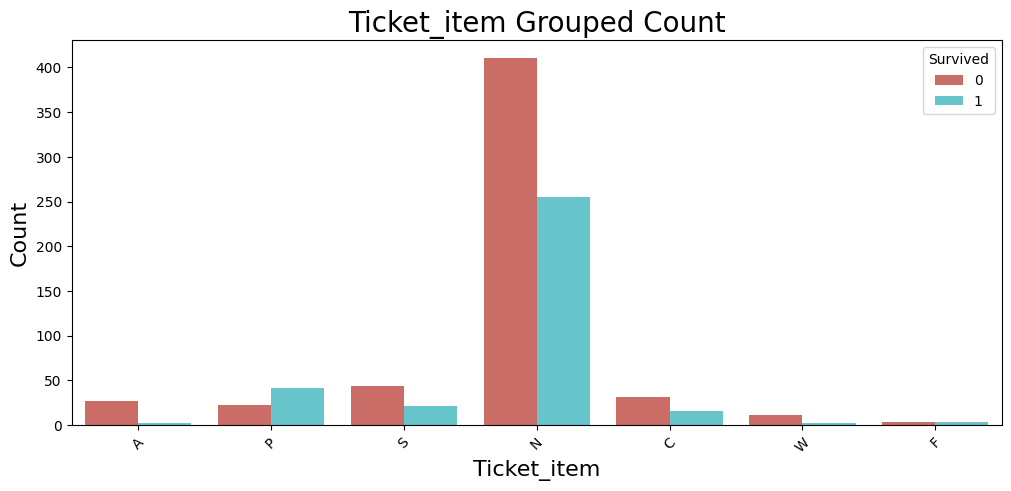

In [43]:
def Ticket_categories(df):
    df = df.copy()
    
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])

    df["Ticket_item"] = df["Ticket"].apply(ticket_item)   

    char_remove = [r".",r"/"]
    for char in char_remove:
        df["Ticket_item"] = df["Ticket_item"].str.replace(char,'')
    
    df["Ticket_item"] = df['Ticket_item'].astype(str).str[0:1]

    return df
  

df_train = Ticket_categories(df_train)
df_test = Ticket_categories(df_test)


#printing the chance to survive by each title
print("Chances to survive based on ticket type: ") 
print(df_train.groupby("Ticket_item")["Survived"].mean())

# figure size
plt.figure(figsize=(12,5))

#Plotting the count of title by Survived or not category
sns.countplot(x='Ticket_item', data=df_train, palette="hls",
              hue="Survived")
plt.xlabel("Ticket_item", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Ticket_item Grouped Count", fontsize=20)
plt.xticks(rotation=45)
plt.show()

This looks like it might be a red herring.  In fact I ran the whole model with these categories included and it made the whole thing worse.  Even messing around with how to group the tickets, it never seemed to make an improvement.  I think this input is just not very clean in the first place.

In [44]:
#Let's group the median age by sex, pclass and title, to have any idea and maybe input in Age NAN's
age_group = df_train.groupby(["Sex","Pclass","Title"])["Age"]

age_group_test = df_test.groupby(["Sex","Pclass","Title"])["Age"]

#printing the variabe that we created by median
print(age_group.median())

print(age_group_test.median())

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royalty    48.0
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royalty    40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64
Sex     Pclass  Title  
female  1       Miss       32.0
                Mrs        48.0
                Royalty    39.0
        2       Miss       19.5
                Mrs        29.0
        3       Miss       22.0
                Mrs        28.0
male    1       Master      9.5
                Mr         42.0
                Officer    53.0
        2       Master      5.0
                Mr         28.

In [45]:
#inputing the values on Age Na's 
df_train.loc[df_train.Age.isnull(), 'Age'] = df_train.groupby(['Sex','Pclass','Title']).Age.transform('median')

df_test.loc[df_test.Age.isnull(), 'Age'] = df_test.groupby(['Sex','Pclass','Title']).Age.transform('median')

# printing the total of nulls in Age Feature
print("Number of AGE nan in train: ")
print(df_train["Age"].isnull().sum())
print("Number of AGE nan in test: ")
print(df_test["Age"].isnull().sum())

#df_test.loc[df_test.Age.isnull()]

# we still have 1 nan in the test data because there is only one person in their sex-title-class group and they are nan.  so we will just give them the overall average.
# this was true before we grouped together different titles into bigger groups.  with bigger groups there weren't any nan medians, but I'm leaving this in because it makes the whole thing more robust.
#df_test.loc[df_test.Age.isnull()]
overall_avg_age = df_train.loc[:,'Age'].mean()

df_train.loc[df_train.Age.isnull(), 'Age'] = overall_avg_age
df_test.loc[df_test.Age.isnull(), 'Age'] = overall_avg_age

print('Ok trying again:')
print("Number of AGE nan in train: ")
print(df_train["Age"].isnull().sum())
print("Number of AGE nan in test: ")
print(df_test["Age"].isnull().sum())


Number of AGE nan in train: 
0
Number of AGE nan in test: 
0
Ok trying again:
Number of AGE nan in train: 
0
Number of AGE nan in test: 
0


Great! we got rid of all the NaNs in the Age column, replacing them with a pretty good guess of what they were

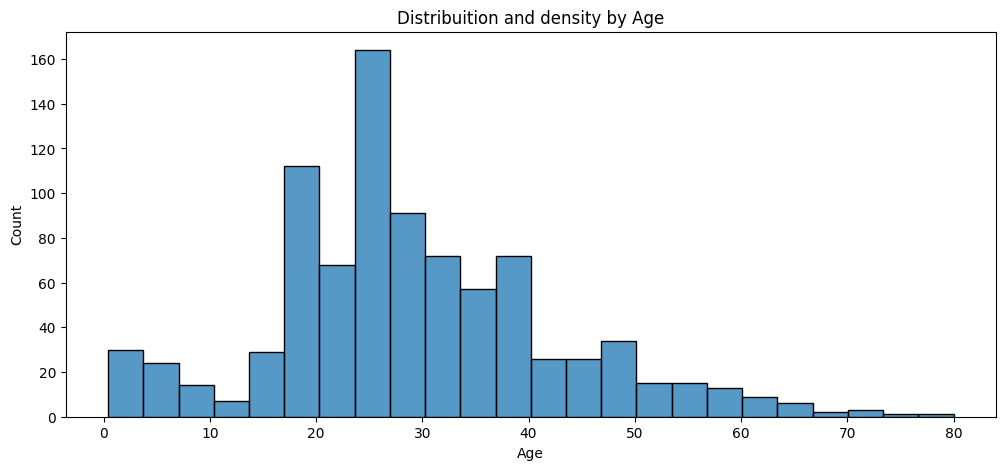

In [46]:
#Let's see the result of the input

#seting the figure size
plt.figure(figsize=(12,5))

#ploting again the Age Distribuition after the transformation in our dataset
sns.histplot(df_train["Age"], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")
plt.show()

In [47]:
#making categories to fit ages into.  may not be needed since age is one of our few continuous variables

#creating the intervals that we need to cut each range of ages
interval = (0, 5, 12, 18, 25, 35, 60, 120) 

#Seting the names that we want use to the categorys
cats = ['babies', 'Children', 'Teen', 'Student', 'Young', 'Adult', 'Senior']

# Applying the pd.cut and using the parameters that we created 
df_train["Age_cat"] = pd.cut(df_train.Age, interval, labels=cats)

# same that we used above in df train
df_test["Age_cat"] = pd.cut(df_test.Age, interval, labels=cats)

# Printing the new Category
df_train["Age_cat"].head()

0    Student
1      Adult
2      Young
3      Young
4      Young
Name: Age_cat, dtype: category
Categories (7, object): ['babies' < 'Children' < 'Teen' < 'Student' < 'Young' < 'Adult' < 'Senior']

Survived    0    1
Fare_cat          
NoInf      14    1
quart_1   175   51
quart_2   155   62
quart_3   112   99
quart_4    93  129


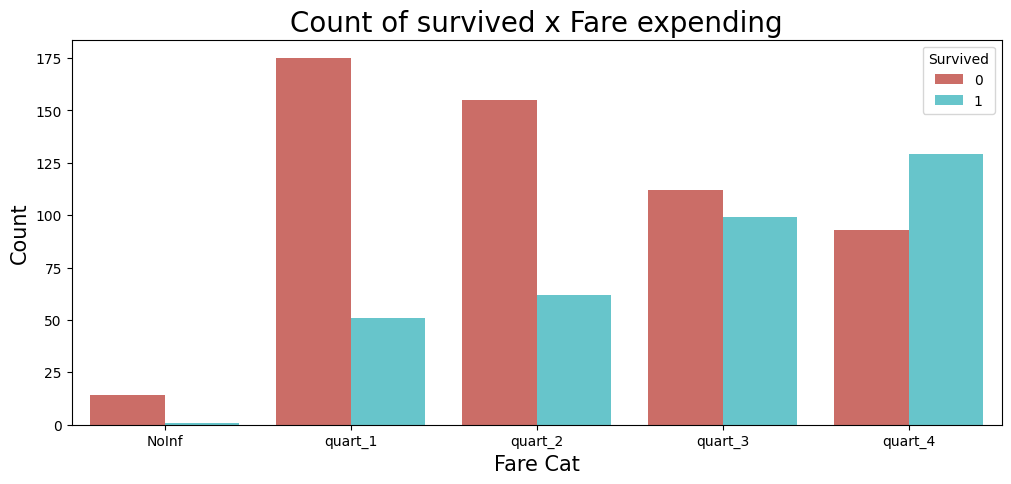

In [48]:
#Filling the NA's with -0.5
df_train.Fare = df_train.Fare.fillna(-0.5)

df_test.Fare = df_test.Fare.fillna(-0.5)

#intervals to categorize
quant = (-1, 0, 8, 15, 31, 600)

#Labels without input values
label_quants = ['NoInf', 'quart_1', 'quart_2', 'quart_3', 'quart_4']

#doing the cut in fare and puting in a new column
df_train["Fare_cat"] = pd.cut(df_train.Fare, quant, labels=label_quants)
df_test["Fare_cat"] = pd.cut(df_test.Fare, quant, labels=label_quants)

#Description of transformation
print(pd.crosstab(df_train.Fare_cat, df_train.Survived))

plt.figure(figsize=(12,5))

#Plotting the new feature
sns.countplot(x="Fare_cat", hue="Survived", data=df_train, palette="hls")
plt.title("Count of survived x Fare expending",fontsize=20)
plt.xlabel("Fare Cat",fontsize=15)
plt.ylabel("Count",fontsize=15)

plt.show()

In [49]:
#Now lets drop the variables that are irrelevant now
#del df_train["Fare"] # keeping fare and dropping fare_cat
del df_train["Fare_cat"]
del df_train["Ticket"]
del df_train["Ticket_item"]
#del df_train["Age"] # we are keeping age and dropping age_cat
del df_train["Age_cat"]
del df_train["Cabin"]
del df_train["Name"]

#same in df_test
#del df_test["Fare"]
del df_test["Fare_cat"]
del df_test["Ticket"]
del df_test["Ticket_item"]
#del df_test["Age"]
del df_test["Age_cat"]
del df_test["Cabin"]
del df_test["Name"]

print(df_train.shape)
print(df_test.shape)

(891, 11)
(418, 10)


In [50]:
#Looking the result of transformations
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_letter
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,n
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,C
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,n
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,C
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,n


Embarked   C   Q    S
Pclass               
1         85   2  127
2         17   3  164
3         66  72  353


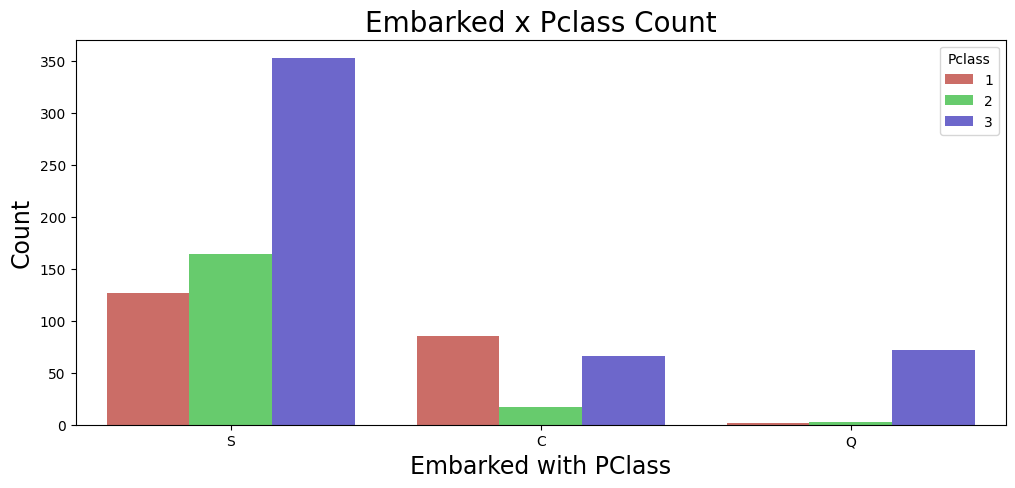

In [51]:
# Distribuition by class
print(pd.crosstab(df_train.Pclass, df_train.Embarked))

plt.figure(figsize=(12,5))

sns.countplot(x="Embarked", data=df_train, hue="Pclass",palette="hls")
plt.title('Embarked x Pclass Count', fontsize=20)
plt.xlabel('Embarked with PClass',fontsize=17)
plt.ylabel('Count', fontsize=17)

plt.show()

In [52]:
#lets input the NA's with the highest frequency
df_train["Embarked"] = df_train["Embarked"].fillna('S')
df_test["Embarked"] = df_test["Embarked"].fillna('S')


Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  219


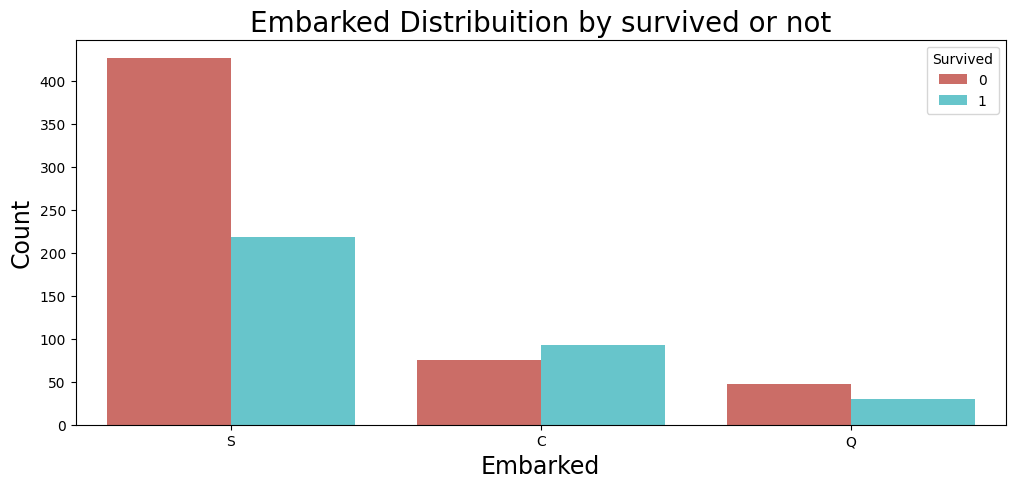

In [53]:
# Exploring Survivors vs Embarked
print(pd.crosstab(df_train.Survived, df_train.Embarked))

plt.figure(figsize=(12,5))

sns.countplot(x="Embarked", data=df_train, hue="Survived",palette="hls")
plt.title('Embarked Distribuition by survived or not',fontsize=20)
plt.xlabel('Embarked',fontsize=17)
plt.ylabel('Count', fontsize=17)

plt.show()

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119


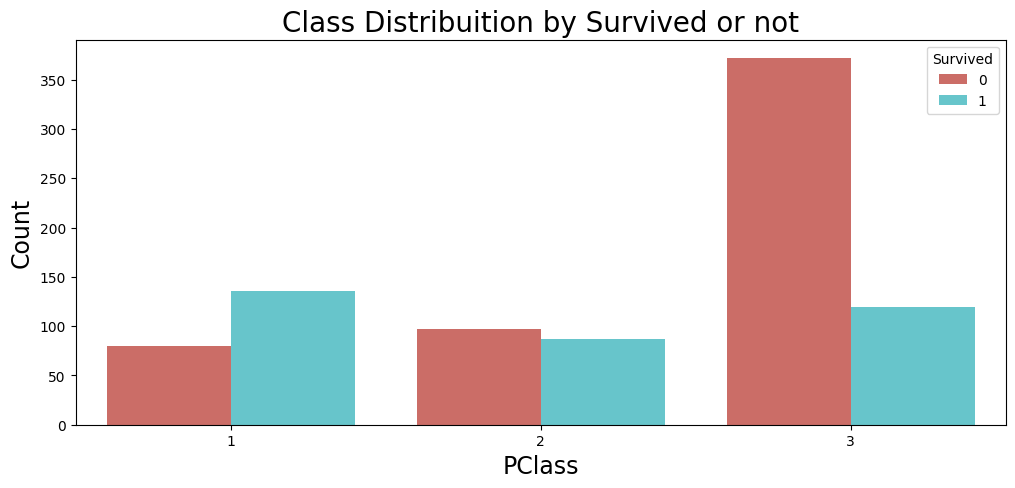

In [54]:
# Exploring Survivors vs Pclass
print(pd.crosstab(df_train.Survived, df_train.Pclass))

plt.figure(figsize=(12,5))

sns.countplot(x="Pclass", data=df_train, hue="Survived",palette="hls")
plt.xlabel('PClass',fontsize=17)
plt.ylabel('Count', fontsize=17)
plt.title('Class Distribuition by Survived or not', fontsize=20)

plt.show()

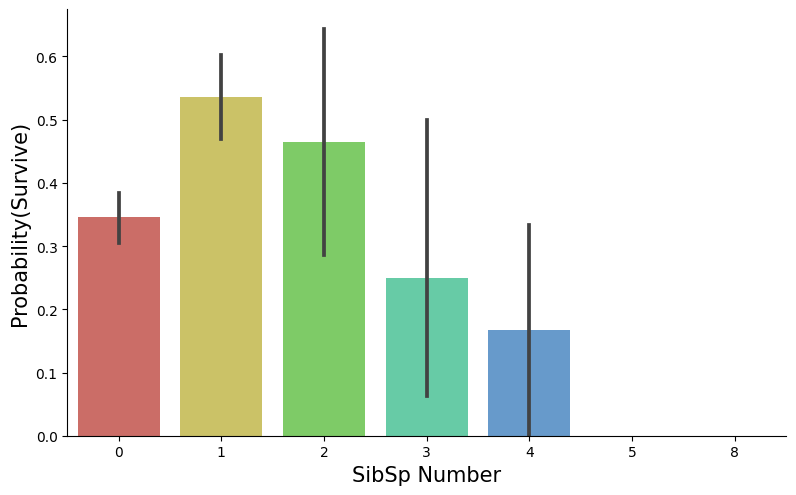

In [55]:
g = sns.catplot(x="SibSp",y="Survived",data=df_train,
                   kind="bar", height = 5, aspect= 1.6, palette = "hls")
g.set_ylabels("Probability(Survive)", fontsize=15)
g.set_xlabels("SibSp Number", fontsize=15)

plt.show()

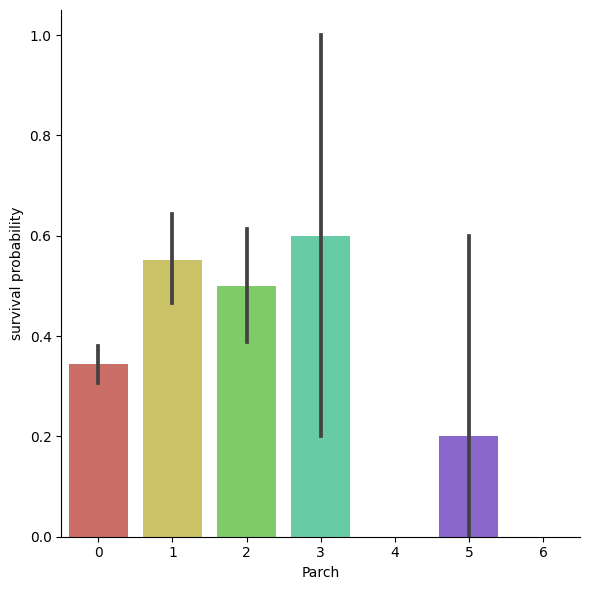

In [56]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch",y="Survived",data=df_train, kind="bar", height = 6,palette = "hls")
g = g.set_ylabels("survival probability")

In [57]:
#Create a new column and sum the Parch + SibSp + 1 that refers the people self
df_train["FSize"] = df_train["Parch"] + df_train["SibSp"] + 1

df_test["FSize"] = df_test["Parch"] + df_test["SibSp"] + 1

Survived    0    1
FSize             
1         374  163
2          72   89
3          43   59
4           8   21
5          12    3
6          19    3
7           8    4
8           6    0
11          7    0


c:\Users\iprosado\My Programs\SQLPathFinder3\python3\lib\site-packages\seaborn\categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


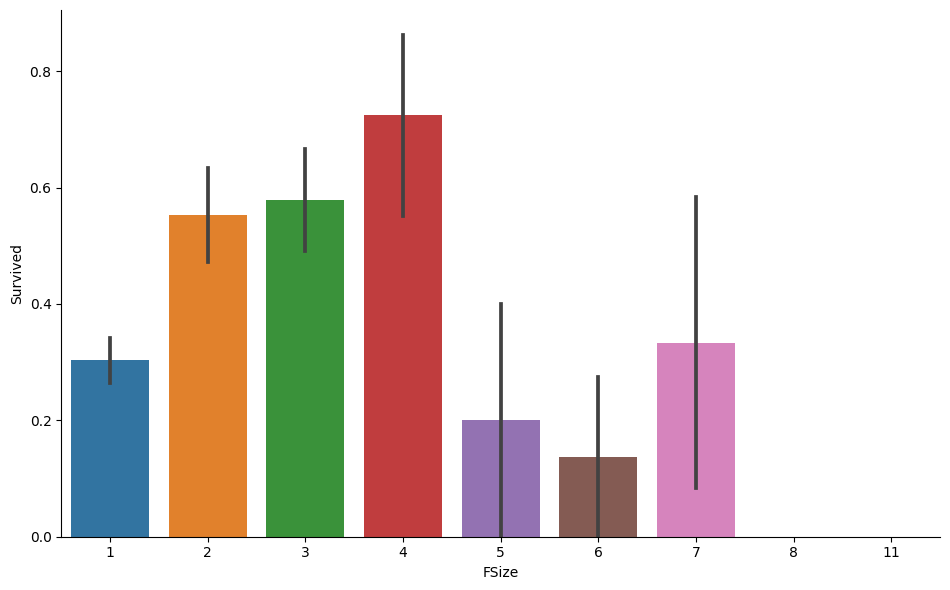

In [58]:
print(pd.crosstab(df_train.FSize, df_train.Survived))
sns.catplot(x="FSize",y="Survived", data=df_train, kind="bar",size=6, aspect=1.6)
plt.show()

In [59]:
del df_train["SibSp"]
del df_train["Parch"]

del df_test["SibSp"]
del df_test["Parch"]


print(df_train.shape)
print(df_test.shape)

print(df_train.head())
print(df_test.head())

(891, 10)
(418, 9)
   PassengerId  Survived  Pclass     Sex   Age     Fare Embarked Title  \
0            1         0       3    male  22.0   7.2500        S    Mr   
1            2         1       1  female  38.0  71.2833        C   Mrs   
2            3         1       3  female  26.0   7.9250        S  Miss   
3            4         1       1  female  35.0  53.1000        S   Mrs   
4            5         0       3    male  35.0   8.0500        S    Mr   

  Cabin_letter  FSize  
0            n      2  
1            C      2  
2            n      1  
3            C      2  
4            n      1  
   PassengerId  Pclass     Sex   Age     Fare Embarked Title Cabin_letter  \
0          892       3    male  34.5   7.8292        Q    Mr            n   
1          893       3  female  47.0   7.0000        S   Mrs            n   
2          894       2    male  62.0   9.6875        Q    Mr            n   
3          895       3    male  27.0   8.6625        S    Mr            n   
4      

In [60]:
df_train = pd.get_dummies(df_train, columns=["Sex","Embarked","Title","Cabin_letter"],\
                          prefix=["Sex","Emb","Prefix","Cabin"], drop_first=True) # removed AGE_cat, FARE_cat

df_test = pd.get_dummies(df_test, columns=["Sex","Embarked","Title","Cabin_letter"],\
                         prefix=["Sex","Emb","Prefix","Cabin"], drop_first=True) # removed AGE_cat,  FARE_cat

# Get missing columns in the training test
missing_cols = set( df_train.columns ) - set( df_test.columns ) 
# missing_cols.remove('Survived')
# print (missing_cols)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_test = df_test[df_train.columns]

df_test = df_test.drop('Survived', axis = 1)

print(df_train.shape)
print(df_test.shape)

df_train.to_csv('train_column_match.csv')
df_test.to_csv('test_column_match.csv')

(891, 22)
(418, 21)


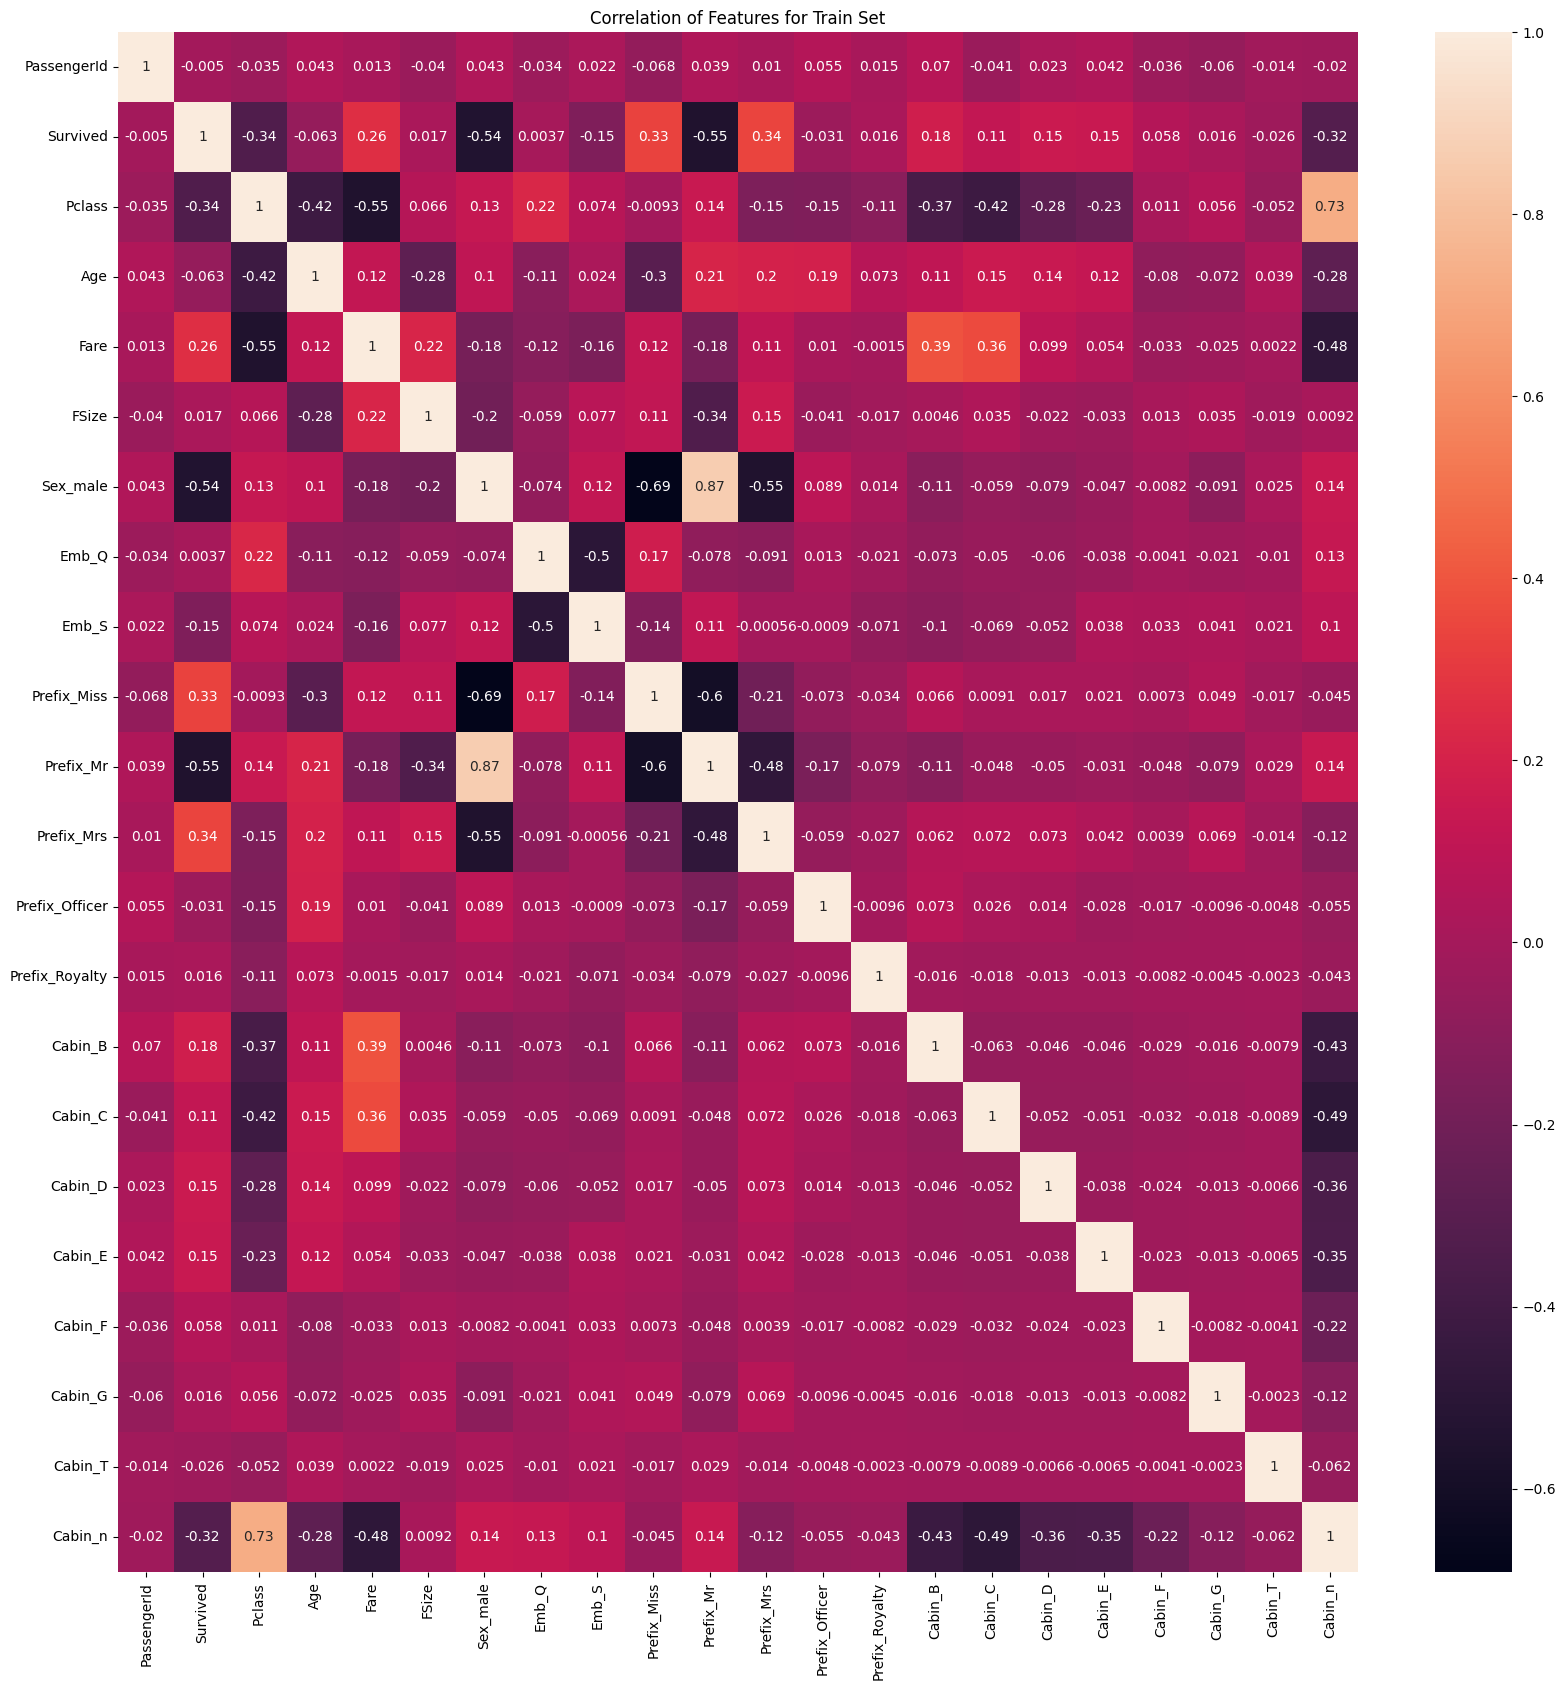

In [61]:
#Finally, lets look the correlation of df_train
#this was more useful when we only had a few features - I've expanded it so it's hard to read
plt.figure(figsize=(20,20))
plt.title('Correlation of Features for Train Set')
sns.heatmap(df_train.astype(float).corr(),vmax=1.0,  annot=True)
plt.show()

## Shuffle the data

In [62]:

shuffled_indices = np.random.RandomState(seed=111).permutation(df_train.index)
df_train = df_train.reindex(shuffled_indices)


df_train.head()

,PassengerId,Survived,Pclass,Age,Fare,FSize,Sex_male,Emb_Q,Emb_S,Prefix_Miss,...,Prefix_Officer,Prefix_Royalty,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_n
374,375,0,3,3.0,21.0750,5,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
211,212,1,2,35.0,21.0000,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
258,259,1,1,35.0,512.3292,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
584,585,0,3,26.0,8.7125,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
461,462,0,3,34.0,8.0500,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


### Split out the targets from the training data and remove passenger ID from both

In [63]:
train = df_train.drop(["Survived","PassengerId"],axis=1)
train_ = df_train["Survived"]

test_ = df_test.drop(["PassengerId"],axis=1)

X_train = train.values
y_train = train_.values

X_test = test_.values
#X_test = X_test.astype(np.float64, copy=False)

columns_list = train.columns

# print(X_train.shape[1])
# print(X_test.shape[1])
# print(train.head())
# print(test_.head())
# print(train_.head())

print(columns_list)


Index(['Pclass', 'Age', 'Fare', 'FSize', 'Sex_male', 'Emb_Q', 'Emb_S',
       'Prefix_Miss', 'Prefix_Mr', 'Prefix_Mrs', 'Prefix_Officer',
       'Prefix_Royalty', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_n'],
      dtype='object')


### Standardize the data

In [64]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


df_train_inputs =pd.DataFrame(X_train, columns=columns_list)
df_test_inputs =pd.DataFrame(X_test, columns=columns_list)

df_train_inputs.to_csv('train_inputs_scaled.csv')
df_test_inputs.to_csv('test_inputs_scaled.csv')

df_train_inputs.describe()



# #create a layer that will fit on our model
# normalize = tf.keras.layers.Normalization()
# normalize.adapt(X_train)

,Pclass,Age,Fare,FSize,Sex_male,Emb_Q,Emb_S,Prefix_Miss,Prefix_Mr,Prefix_Mrs,Prefix_Officer,Prefix_Royalty,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_n
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-1.138882e-16,2.529464e-16,-2.666529e-17,2.075905e-16,-2.494575e-16,-2.696434e-16,5.980999e-17,6.280049e-17,-3.812887e-16,-2.728831e-17,3.569909e-17,1.930430e-16,7.332955e-17,-1.903951e-16,2.875864e-16,-1.925134e-16,-9.541563e-17,1.871554e-16,-2.562329e-16,-1.622346e-16
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-1.566107e+00,-2.129233e+00,-6.484217e-01,-5.609748e-01,-1.355574e+00,-3.075623e-01,-1.623803e+00,-5.101515e-01,-1.175735e+00,-4.077136e-01,-1.435916e-01,-6.715343e-02,-2.359814e-01,-2.662958e-01,-1.961161e-01,-1.930094e-01,-1.216815e-01,-6.715343e-02,-3.352008e-02,-1.835115e+00
25%,-3.693648e-01,-6.033866e-01,-4.891482e-01,-5.609748e-01,-1.355574e+00,-3.075623e-01,-1.623803e+00,-5.101515e-01,-1.175735e+00,-4.077136e-01,-1.435916e-01,-6.715343e-02,-2.359814e-01,-2.662958e-01,-1.961161e-01,-1.930094e-01,-1.216815e-01,-6.715343e-02,-3.352008e-02,5.449250e-01
50%,8.273772e-01,-2.326758e-01,-3.573909e-01,-5.609748e-01,7.376951e-01,-3.075623e-01,6.158384e-01,-5.101515e-01,8.505317e-01,-4.077136e-01,-1.435916e-01,-6.715343e-02,-2.359814e-01,-2.662958e-01,-1.961161e-01,-1.930094e-01,-1.216815e-01,-6.715343e-02,-3.352008e-02,5.449250e-01
75%,8.273772e-01,5.643526e-01,-2.424635e-02,5.915988e-02,7.376951e-01,-3.075623e-01,6.158384e-01,-5.101515e-01,8.505317e-01,-4.077136e-01,-1.435916e-01,-6.715343e-02,-2.359814e-01,-2.662958e-01,-1.961161e-01,-1.930094e-01,-1.216815e-01,-6.715343e-02,-3.352008e-02,5.449250e-01
max,8.273772e-01,3.771002e+00,9.667167e+00,5.640372e+00,7.376951e-01,3.251373e+00,6.158384e-01,1.960202e+00,8.505317e-01,2.452702e+00,6.964194e+00,1.489127e+01,4.237623e+00,3.755222e+00,5.099020e+00,5.181095e+00,8.218179e+00,1.489127e+01,2.983287e+01,5.449250e-01


### Modeling

In [65]:
from keras.layers import  Dropout
from keras.optimizers import SGD

In [66]:
# Set the input and output sizes
num_inputs = X_train.shape[1]
input_size = num_inputs
output_size = 1
# Use same hidden layer size for both hidden layers. Not a necessity.
hidden_layer_size = 50

# define how the model will look like
model = tf.keras.Sequential([
    #normalize,
    tf.keras.layers.Dense(18, activation='relu',  input_dim=input_size, kernel_initializer='uniform'), # 1st hidden layer
    Dropout(0.50),
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    Dropout(0.50),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    Dropout(0.50),
    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(output_size, activation='sigmoid', kernel_initializer='uniform') # output layer
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                378       
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                950       
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5

In [67]:
#Creating an Stochastic Gradient Descent
sgd = SGD(lr = 0.01, momentum = 0.9)

# Compiling our model
#model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)


# Fitting the ANN to the Training set
model.fit(X_train, y_train, 
            batch_size = 60, 
            epochs = 100,
            validation_split = 0.2,
            callbacks=[early_stopping], # early stopping
            verbose=2)

c:\Users\iprosado\My Programs\SQLPathFinder3\python3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
12/12 - 0s - loss: 0.6910 - accuracy: 0.5716 - val_loss: 0.6828 - val_accuracy: 0.6536 - 464ms/epoch - 39ms/step
Epoch 2/100
12/12 - 0s - loss: 0.6825 - accuracy: 0.6067 - val_loss: 0.6706 - val_accuracy: 0.6536 - 31ms/epoch - 3ms/step
Epoch 3/100
12/12 - 0s - loss: 0.6730 - accuracy: 0.6053 - val_loss: 0.6599 - val_accuracy: 0.6536 - 36ms/epoch - 3ms/step
Epoch 4/100
12/12 - 0s - loss: 0.6676 - accuracy: 0.6096 - val_loss: 0.6513 - val_accuracy: 0.6536 - 37ms/epoch - 3ms/step
Epoch 5/100
12/12 - 0s - loss: 0.6596 - accuracy: 0.6124 - val_loss: 0.6412 - val_accuracy: 0.6536 - 34ms/epoch - 3ms/step
Epoch 6/100
12/12 - 0s - loss: 0.6458 - accuracy: 0.6433 - val_loss: 0.6269 - val_accuracy: 0.6592 - 39ms/epoch - 3ms/step
Epoch 7/100
12/12 - 0s - loss: 0.6352 - accuracy: 0.6587 - val_loss: 0.6070 - val_accuracy: 0.7486 - 38ms/epoch - 3ms/step
Epoch 8/100
12/12 - 0s - loss: 0.6034 - accuracy: 0.7303 - val_loss: 0.5795 - val_accuracy: 0.7598 - 33ms/epoch - 3ms/step
Epoch 9/100
12

In [68]:
y_preds = model.predict(X_test)
np.savetxt('y_preds_simpler.csv', y_preds, delimiter=',')
df_y_preds = pd.DataFrame(y_preds, columns=['Survived'])

submission = pd.read_csv("gender_submission.csv")#, index_col='PassengerId')

submission = submission.drop('Survived',axis = 1)
submission['Survived'] = df_y_preds['Survived'].round(0).astype(int)
submission.to_csv('Titanic_NN_submission.csv',index=False)
df_y_preds.to_csv('y_preds_simple.csv')

#df_y_preds.describe()
#df_y_preds.head()
submission.describe()
#submission.head()

14/14 [==============================] - 0s 1ms/step


,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.272727
std,120.810458,0.445895
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [69]:
scores = model.evaluate(X_train, y_train, batch_size=30)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

30/30 [==============================] - 0s 1ms/step - loss: 0.3892 - accuracy: 0.8485
accuracy: 84.85%


In [70]:
# Fit the model
history = model.fit(X_train, y_train, validation_split=0.20, 
                    epochs=180, batch_size=10, verbose=0)

# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


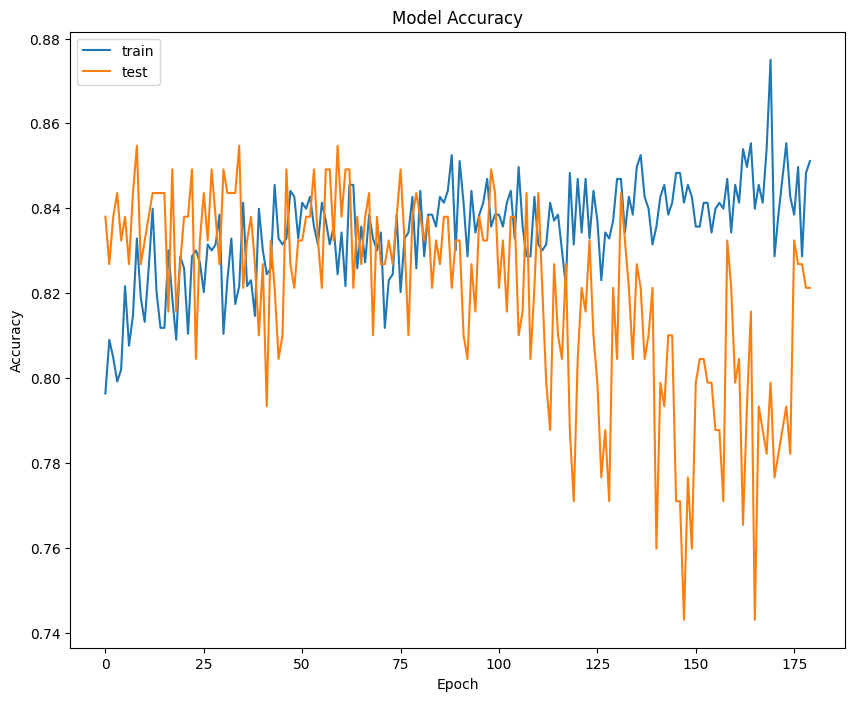

In [71]:
# summarizing historical accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

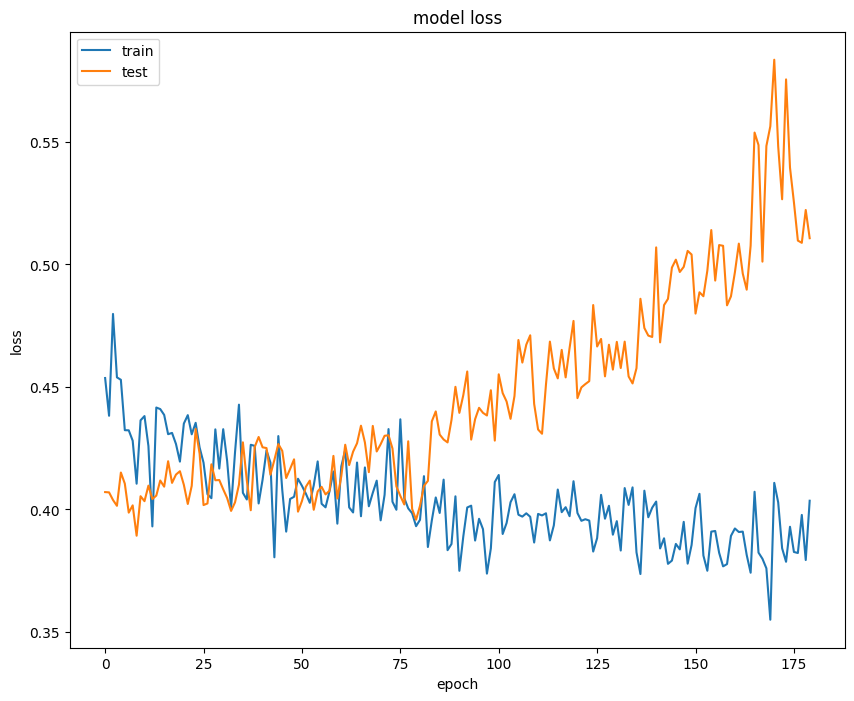

In [72]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()